# Hyper-Parameter Tuning

This notebook outlines the hyper-parameter optimisation procedure used to tune the models

<br>

### Imports

In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import train_test_split
from skopt.plots import plot_objective
from skopt.space import Real, Integer

import matplotlib.pyplot as plt

from moepy import lowess, eda

<br>

### Data Loading

We'll start with the GB data

In [2]:
df_EI = eda.load_EI_df('../data/raw/electric_insights.csv')
df_EI_model = df_EI[['day_ahead_price', 'demand', 'solar', 'wind']].dropna()

s_price = df_EI_model['day_ahead_price']
s_dispatchable = df_EI_model['demand'] - df_EI_model[['solar', 'wind']].sum(axis=1)

s_dispatchable.head()

local_datetime
2009-01-01 00:00:00+00:00    38.181
2009-01-01 00:30:00+00:00    38.304
2009-01-01 01:00:00+00:00    37.839
2009-01-01 01:30:00+00:00    36.716
2009-01-01 02:00:00+00:00    36.020
dtype: float64

<br>

then also load in the DE data

In [3]:
df_DE = eda.load_DE_df('../data/raw/energy_charts.csv', '../data/raw/ENTSOE_DE_price.csv')

df_DE_model = df_DE[['price', 'demand', 'Solar', 'Wind']].dropna()

s_DE_demand = df_DE_model['demand']
s_DE_price = df_DE_model['price']
s_DE_dispatchable = df_DE_model['demand'] - df_DE_model[['Solar', 'Wind']].sum(axis=1)

<br>

### Monkey Patching `skopt`

Due to some changes in the latest release of `scikit-learn` several classes and functions in `skopt` were broken at the time this research was carried out. This section provides code for monkey-patching `skopt` to ensure that it continues working.

We'll start by loading in the relevant imports

In [4]:
from joblib import Parallel, delayed
from scipy.stats import rankdata
from skopt import BayesSearchCV

import os
import codecs
from ipypb import track
from warnings import warn
from functools import partial
from distutils.dir_util import copy_tree
from collections.abc import Iterable, Sized
from collections import defaultdict

import sklearn 
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import is_classifier, clone
from sklearn.utils.validation import indexable

try:
    from sklearn.metrics import check_scoring
except ImportError:
    from sklearn.metrics.scorer import check_scoring

<br>

We'll re-define the `bayes_search_CV_init` function

In [5]:
def bayes_search_CV_init(self, estimator, search_spaces, optimizer_kwargs=None,
                         n_iter=50, scoring=None, fit_params=None, n_jobs=1,
                         n_points=1, iid=True, refit=True, cv=None, verbose=0,
                         pre_dispatch='2*n_jobs', random_state=None,
                         error_score='raise', return_train_score=False):

        self.search_spaces = search_spaces
        self.n_iter = n_iter
        self.n_points = n_points
        self.random_state = random_state
        self.optimizer_kwargs = optimizer_kwargs
        self._check_search_space(self.search_spaces)
        self.fit_params = fit_params
        self.iid = None

        super(BayesSearchCV, self).__init__(
             estimator=estimator, scoring=scoring,
             n_jobs=n_jobs, refit=refit, cv=cv, verbose=verbose,
             pre_dispatch=pre_dispatch, error_score=error_score,
             return_train_score=return_train_score)

BayesSearchCV.__init__ = bayes_search_CV_init

<br>

As well as the `bayes_search_CV__fit` function

In [6]:
def bayes_search_CV__fit(self, X, y, groups, parameter_iterable):
    """
    Actual fitting,  performing the search over parameters.
    Taken from https://github.com/scikit-learn/scikit-learn/blob/0.18.X
                .../sklearn/model_selection/_search.py
    """
    estimator = self.estimator
    cv = sklearn.model_selection._validation.check_cv(
        self.cv, y, classifier=is_classifier(estimator))
    self.scorer_ = check_scoring(
        self.estimator, scoring=self.scoring)

    X, y, groups = indexable(X, y, groups)
    n_splits = cv.get_n_splits(X, y, groups)
    if self.verbose > 0 and isinstance(parameter_iterable, Sized):
        n_candidates = len(parameter_iterable)
        print("Fitting {0} folds for each of {1} candidates, totalling"
              " {2} fits".format(n_splits, n_candidates,
                                 n_candidates * n_splits))

    base_estimator = clone(self.estimator)
    pre_dispatch = self.pre_dispatch

    cv_iter = list(cv.split(X, y, groups))
    out = Parallel(
        n_jobs=self.n_jobs, verbose=self.verbose,
        pre_dispatch=pre_dispatch
    )(delayed(sklearn.model_selection._validation._fit_and_score)(
            clone(base_estimator),
            X, y, self.scorer_,
            train, test, self.verbose, parameters,
            fit_params=self.fit_params,
            return_train_score=self.return_train_score,
            return_n_test_samples=True,
            return_times=True, return_parameters=True,
            error_score=self.error_score
        )
        for parameters in parameter_iterable
        for train, test in cv_iter)

    # if one choose to see train score, "out" will contain train score info
    if self.return_train_score:
        (train_scores, test_scores, n_test_samples,
         fit_time, score_time, parameters) = zip(*out)
    else:
        from warnings import warn
        (fit_failed, test_scores, n_test_samples,
         fit_time, score_time, parameters) = zip(*[a.values() for a in out])

    candidate_params = parameters[::n_splits]
    n_candidates = len(candidate_params)

    results = dict()

    def _store(key_name, array, weights=None, splits=False, rank=False):
        """A small helper to store the scores/times to the cv_results_"""
        array = np.array(array, dtype=np.float64).reshape(n_candidates,
                                                          n_splits)
        if splits:
            for split_i in range(n_splits):
                results["split%d_%s"
                        % (split_i, key_name)] = array[:, split_i]

        array_means = np.average(array, axis=1, weights=weights)
        results['mean_%s' % key_name] = array_means
        # Weighted std is not directly available in numpy
        array_stds = np.sqrt(np.average((array -
                                         array_means[:, np.newaxis]) ** 2,
                                        axis=1, weights=weights))
        results['std_%s' % key_name] = array_stds

        if rank:
            results["rank_%s" % key_name] = np.asarray(
                rankdata(-array_means, method='min'), dtype=np.int32)

    # Computed the (weighted) mean and std for test scores alone
    # NOTE test_sample counts (weights) remain the same for all candidates n_test_samples
    n_test_samples = np.array(n_test_samples[:n_splits],
                                  dtype=np.int)

    _store('test_score', test_scores, splits=True, rank=True,
           weights=n_test_samples if self.iid else None)
    if self.return_train_score:
        _store('train_score', train_scores, splits=True)
    _store('fit_time', fit_time)
    _store('score_time', score_time)

    best_index = np.flatnonzero(results["rank_test_score"] == 1)[0]
    best_parameters = candidate_params[best_index]

    # Use one MaskedArray and mask all the places where the param is not
    # applicable for that candidate. Use defaultdict as each candidate may
    # not contain all the params
    param_results = defaultdict(partial(np.ma.array,
                                        np.empty(n_candidates,),
                                        mask=True,
                                        dtype=object))
    for cand_i, params in enumerate(candidate_params):
        for name, value in params.items():
            # An all masked empty array gets created for the key
            # `"param_%s" % name` at the first occurence of `name`.
            # Setting the value at an index also unmasks that index
            param_results["param_%s" % name][cand_i] = value

    results.update(param_results)

    # Store a list of param dicts at est_sample_counts = np.array(n_test_samples[:n_splits], key 'params'
    results['params'] = candidate_params

    self.cv_results_ = results
    self.best_index_ = best_index
    self.n_splits_ = n_splits

    if self.refit:
        # fit the best estimator using the entire dataset
        # clone first to work around broken estimators
        best_estimator = clone(base_estimator).set_params(
            **best_parameters)
        if y is not None:
            best_estimator.fit(X, y, **self.fit_params)
        else:
            best_estimator.fit(X, **self.fit_params)
        self.best_estimator_ = best_estimator
    return self

BayesSearchCV._fit = bayes_search_CV__fit

<br>

### Optimisation

We're now ready to carry out our model optimisation

In [7]:
%%time

start_date = '2017-01-01'
end_date = '2019-01-01'
    
x = s_DE_dispatchable[start_date:end_date]
y = s_DE_price[start_date:end_date]
pred_reg_dates = pd.date_range(start_date, end_date, freq='D')

lowess_dates = lowess.LowessDates(frac=0.5, threshold_value=26, pred_reg_dates=pred_reg_dates)

search_spaces = {
        'frac': Real(0.35, 1, 'uniform'),
        'threshold_value': Integer(10, 52, 'uniform')
}

fit_params = {
    'reg_dates': pd.date_range(start_date, end_date, freq='7W'),
    'num_fits': 10,
    'reg_anchors': np.round(np.arange(np.floor(x.min())-5, np.ceil(x.max())+5, 0.1), 1)
}

opt = BayesSearchCV(
    lowess_dates,
    search_spaces,
    optimizer_kwargs={
        'random_state': 42
    },
    n_iter=30,
    verbose=0,
    cv=4, # 8 works well for me as that's how many concurrent workers I can use
    fit_params=fit_params,
    n_jobs=5 # -1
)

fit_BayesSearchCV = True

if fit_BayesSearchCV == True:
    opt.fit(x.round(1), y)

    print(f'Cross-validation score: {opt.best_score_:.2f}')
    print(f'\nBest params: \n{opt.best_params_}')

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   4 out of   4 | elapsed:  4.1min finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=5)]: Done   4 out of   4 | elapsed:  4.5min finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=5)]: Done   4 out of   4 | elapsed:  4.5min finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=5)]: Done   4 out of   4 | elapsed:  4.7min finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=5)]: Done   4 out of   4 | elapsed:  4.5min finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=5)]: Done   4 out of   4 | elapsed:  3.8min finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=5)]: Done   4 out of   4 | elapsed:  3.4min finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=5)]: Done   4 out of   4 | elapsed:  3.5min finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=5)]: Done   4 out of   4 | elapsed:  3.1min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   4 out of   4 | elapsed:  3.1min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   4 out of   4 | elapsed:  2.9min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   4 out of   4 | elapsed:  3.1min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   4 out of   4 | elapsed:  3.4min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   4 out of   4 | elapsed:  3.4min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   4 out of   4 | elapsed:  2.9min finished


 [████████████████████████████████████████████████████████████] 15/15 [02:25<00:10, 9.69s/it]

c:\users\ayrto\desktop\phd\analysis\merit-order-effect\moepy\lowess.py:145: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas = np.linalg.lstsq(A, b)[0]


Cross-validation score: 0.39

Best params: 
OrderedDict([('frac', 0.35), ('threshold_value', 29)])
Wall time: 57min 11s


<br>

We'll visualise the fitted objective surface

Text(0, 0.5, 'Date Smoothing\nBandwidth (Weeks)')

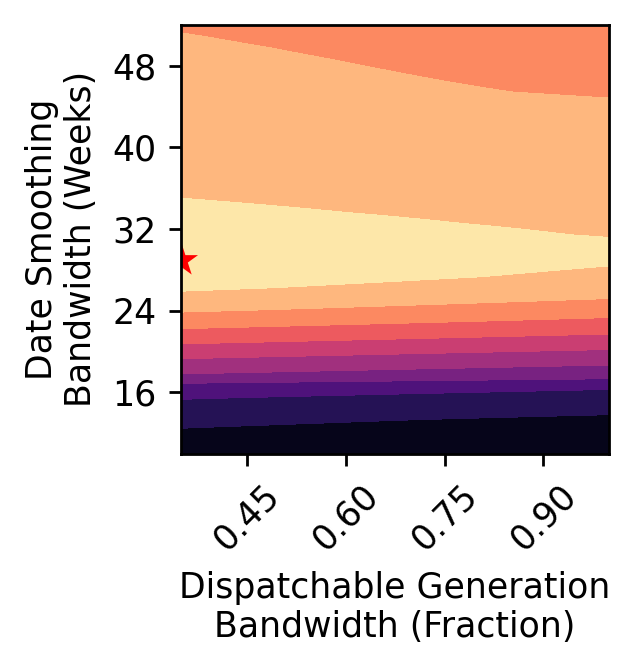

In [8]:
axs = plot_objective(opt.optimizer_results_[0], cmap='magma_r', show_points=False)

fig =  plt.gcf()
fig.set_dpi(250)
fig.delaxes(axs[0][0])
fig.delaxes(axs[0][1])
fig.delaxes(axs[1][1])

ax = axs[1][0]
ax.set_xlabel('Dispatchable Generation\nBandwidth (Fraction)')
ax.set_ylabel('Date Smoothing\nBandwidth (Weeks)')